# **Moving Beyond Linearity**

### 2025-03-19
### **赵伟皓、赵吕宇佳**

## **理论介绍**

In [4]:
# 导入常规库包
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (summarize, poly, ModelSpec as MS)
from statsmodels.stats.anova import anova_lm
import warnings
warnings.filterwarnings('ignore')

In [5]:
# 一些进阶导入的库包。其中许多都是专门为ISLP软件包开发的。
from pygam import (s as s_gam, l as l_gam, f as f_gam, LinearGAM, LogisticGAM)
from ISLP.transforms import (BSpline, NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam, degrees_of_freedom, plot as plot_gam, anova as anova_gam)

- 在本实现中，演示了一些非线性模型。
- 我们使用Wage数据作为一个运行的示例，并展示了所讨论的许多复杂的非线性帧转换过程都可以很容易地在Python中实现。

---

## **1. PolynomialRegression and Step Functions**

In [8]:
 Wage = load_data('Wage')
 y = Wage['wage']
 age = Wage['age']

### **1.1 多项式回归**  
在本实验的大部分时间里，我们的**因变量**是**工资**，我们将其存储为上述y。  
我们将使用poly（）函数创建一个模型矩阵，该矩阵将拟合**年龄**为4次多项式。

In [10]:
# 使用数据框 Wage 执行fit()方法。
poly_age = MS([poly('age', degree=4)]).fit(Wage)
# 这将重新计算Poly()在训练数据上所需的任何参数并将其存储为属性，这些参数将用于transform()方法的所有后续评估
M = sm.OLS(y, poly_age.transform(Wage)).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.283,0.000
"poly(age, degree=4)[0]",447.0679,39.915,11.201,0.000
"poly(age, degree=4)[1]",-478.3158,39.915,-11.983,0.000
"poly(age, degree=4)[2]",125.5217,39.915,3.145,0.002
"poly(age, degree=4)[3]",-77.9112,39.915,-1.952,0.051


- 该多项式是使用函数poly()构造的，该函数创建了一个特殊的**转换器**poly()。**转换器：Transfomer**
- 使用sklearn术语进行特征变换，可以在新数据点轻松计算多项式。
- 这里poly()被称为**帮助**函数，并设置转换；poly()是计算转换的实际主力。 **帮助：helper**

In [12]:
# 我们现在为我们想要预测的年龄值创建一个网格。
age_grid = np.linspace(age.min(), age.max(), 100)
age_df = pd.DataFrame({'age': age_grid})
age_df

,age
0,18.000000
1,18.626263
2,19.252525
3,19.878788
4,20.505051
...,...
95,77.494949
96,78.121212
97,78.747475
98,79.373737


- 最后，绘制数据并添加四次多项式的拟合。  
- 由于要绘制几个类似的图，首先编写一个函数来创建所有成分并生成图。  
- 此函数接受一个模型规范（这里是由转换指定的基础），以及一个年龄值网格。函数生成拟合曲线和95%置信区间。  
- 通过使用参数作为基础，我们可以使用几个不同的变换来生成和绘制结果，（后面会讲到的样条曲线。）

In [14]:
 def plot_wage_fit(age_df, basis, title):

    X = basis.transform(Wage)
    Xnew = basis.transform(age_df)
    M = sm.OLS(y, X).fit()
    preds = M.get_prediction(Xnew)
    bands = preds.conf_int(alpha=0.05)
    fig, ax = subplots(figsize=(8,8)) 
    ax.scatter(age, y, facecolor='gray', alpha=0.5)  # 参数alpha，用于增加点的透明度
    for val, ls in zip([preds.predicted_mean, bands[:,0], bands[:,1]], ['b','r--','r--']):
        # 有三条线要绘制，每条线都有不同的颜色和线型。zip函数将这些作为循环中的迭代器绑定在一起。
        ax.plot(age_df.values, val, ls, linewidth=3)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('Age', fontsize=20)
    ax.set_ylabel('Wage', fontsize=20);
    return ax

**P.S: 在Python中，“迭代器”是一个具有有限数量值的对象，可以在循环中迭代。**

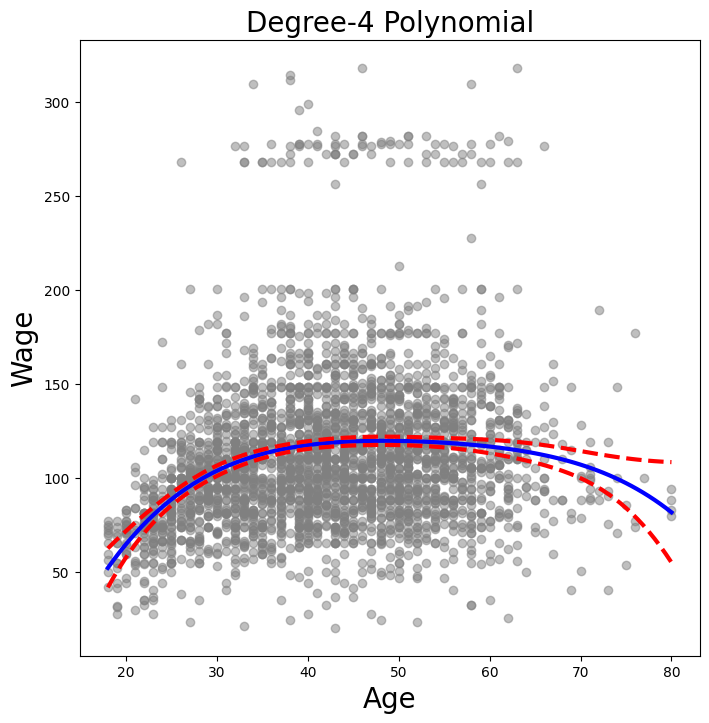

In [16]:
# 我们现在使用此函数绘制四次多项式的拟合。
plot_wage_fit(age_df, poly_age, 'Degree-4 Polynomial');

- **对于多项式回归，必须决定要使用的多项式的degree**。
    - 有时我们只是改变它，并决定使用二次或三次多项式，只是为了获得一个**非线性拟合**。
- 但我们可以更系统地做出这样的决定。
    - 一种方法是通过**假设检验**：
    - 现在建立了一系列的模型，从线性（一次）到一次多项式，并寻找最简单的模型来解释工资和年龄之间的关系。

In [18]:
models = [MS([poly('age', degree=d)])
          for d in range(1, 6)]
Xs = [model.fit_transform(Wage) for model in models]
# 此函数接受可变数量的非关键字参数，在本例中为拟合模型。
anova_lm(*[sm.OLS(y, X_).fit() # 当这些模型以列表形式提供时，必须通过写入“*”星号进行预处理 
           for X_ in Xs])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


- 线性模型[0]与二次模型[1]的p值基本为零，说明线性拟合不适用。
- 同样，比较二次模型[1]和三次模型[2]的p值也很低（0.0017），所以二次拟合也是绝缘的。
- 比较三次和次-四多项式、模型[2]和模型[3]的p值约为5%，
- 而次-fve多项式模型[4]似乎不必要，因为它的p值是0.37。
- **因此，三次或四次多项式似乎为数据提供了一个合理的拟合，但低阶或高阶模型是不合理的**。

In [20]:
# 在这种情况下，我们不用使用anova()函数，我们可以利用ploy()创建正交多项式这一事实来更简洁地获得这些p值。
summarize(M)

,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.283,0.000
"poly(age, degree=4)[0]",447.0679,39.915,11.201,0.000
"poly(age, degree=4)[1]",-478.3158,39.915,-11.983,0.000
"poly(age, degree=4)[2]",125.5217,39.915,3.145,0.002
"poly(age, degree=4)[3]",-77.9112,39.915,-1.952,0.051


In [21]:
# p值是相同的，并且实际上t统计量的平方等于来自anova_lm()函数的f统计量；例如：
(-11.983)**2

143.59228900000002

然而，无论我们是否使用正交多项式，只要模型是**嵌套**的，anova（方差分析）方法都是有效的。  
例如，我们可以使用anova_lm（）来比较以下三个模型，它们在**教育**中都有一个线性项，在不同程度的**年龄**中都有一个多项式：

In [23]:
models = [MS(['education', poly('age', degree=d)])
          for d in range(1, 4)]
XEs = [model.fit_transform(Wage)
       for model in models]
anova_lm(*[sm.OLS(y, X_).fit() for X_ in XEs])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2997.0,3.902335e+06,0.0,NaN,NaN,NaN
1,2996.0,3.759472e+06,1.0,142862.701185,113.991883,3.838075e-26
2,2995.0,3.753546e+06,1.0,5926.207070,4.728593,2.974318e-02


### 作为使用假设检验和方差分析的一种**替代方法**，我们可以使用**交叉验证**来选择多项式的degree。
- 接下来，我们将考虑预测一个人的年收入是否超过25万美元的任务。
- 首先创建适当的响应向量，然后使用二项式家族应用glm（）函数来构建多项式逻辑回归模型。

In [25]:
X = poly_age.transform(Wage)
high_earn = Wage['high_earn'] = y > 250
glm = sm.GLM(y > 250, X, family=sm.families.Binomial())
B = glm.fit()
summarize(B)

,coef,std err,z,P>|z|
intercept,-4.3012,0.345,-12.457,0.000
"poly(age, degree=4)[0]",71.9642,26.133,2.754,0.006
"poly(age, degree=4)[1]",-85.7729,35.929,-2.387,0.017
"poly(age, degree=4)[2]",34.1626,19.697,1.734,0.083
"poly(age, degree=4)[3]",-47.4008,24.105,-1.966,0.049


In [26]:
# 我们再次使用get_prediction（）方法进行预测。
newX = poly_age.transform(age_df)
preds = B.get_prediction(newX)
bands = preds.conf_int(alpha=0.05)

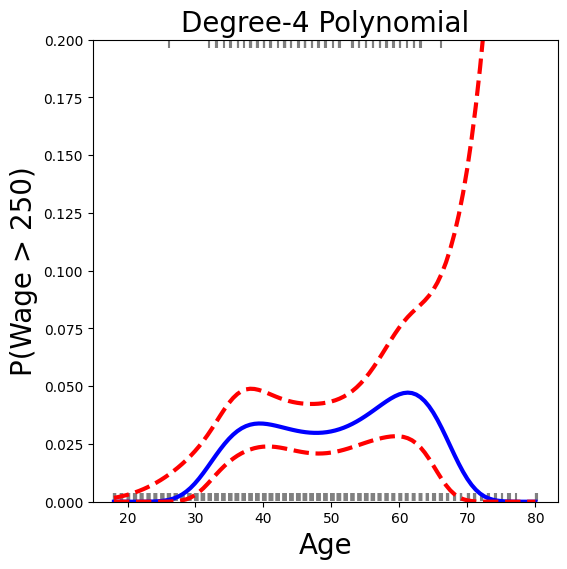

In [27]:
# 我们现在绘制估计的关系图。
fig, ax = subplots(figsize=(6,6))
rng = np.random.default_rng(0)
ax.scatter(age + 0.2 * rng.uniform(size=y.shape[0]), np.where(high_earn, 0.198, 0.002), fc='gray', marker='|')
for val, ls in zip([preds.predicted_mean,
                    bands[:,0],
                    bands[:,1]],
                   ['b','r--','r--']):
    ax.plot(age_df.values, val, ls, linewidth=3)
ax.set_title('Degree-4 Polynomial', fontsize=20)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylim([0,0.2])
ax.set_ylabel('P(Wage > 250)', fontsize=20);

图片的顶部绘制了与工资值大于250的观察值对应的年龄值作为灰色标记，而那些工资值低于250的年龄值在图的底部显示为灰色标记。
这里添加了少量的噪声来抖动年龄值，这样具有相同年龄值的观测值就不会相互覆盖。这种类型的绘图通常被称为**地毯图**。

### **1.2 阶跃函数**
- 为了拟合**阶跃函数**，我们首先使用pd.qcut（）函数根据分位数对年龄进行离散化。
- 然后使用pd.get_dummies（）正则变量。此函数将包括为给定的pd.get_dummies（）分类创建模型矩阵的列，而不是通常的方法，即删除其中一个级别。

In [30]:
cut_age = pd.qcut(age, 4)

summarize(sm.OLS(y, pd.get_dummies(cut_age)).fit())

,coef,std err,t,P>|t|
"(17.999, 33.75]",94.1584,1.478,63.692,0.0
"(33.75, 42.0]",116.6608,1.470,79.385,0.0
"(42.0, 51.0]",119.1887,1.416,84.147,0.0
"(51.0, 80.0]",116.5717,1.559,74.751,0.0


- 这里，pd.qcut（）根据分位数25%、50%和75%自动选择切割点，从而产生四个区域。也可以直接指定自己的分位数，而不是参数4。
- 对于不基于分位数的切割，我们将使用pd.cut（）函数。函数pd.qcut（和pd.cut（））返回一个有序的分类变量。
- 然后，回归模型创建一组虚拟变量用于回归。由于年龄是模型中唯一的变量，因此94158.40美元是33.75岁以下人群的平均工资，其他系数是其他年龄段人群的平均收入。

---
---

## **2. Splines**
- 为了拟合回归样条，我们使用ISLP包中的**transforms**。
- 实际样条评估函数在sciy.interpole包中；我们只是将它们包装为类似于Poly()和PCA()的转换。

(1) 回归样条可以通过构建适当的基函数矩阵来拟合。   
(2) **BSpline()函数为具有指定节点集的样条生成整个基函数矩阵**。  
(3) 默认情况下，生成的B样条带是**三次的。要更改度数，应使用参数'degree'**。

In [34]:
bs_ = BSpline(internal_knots=[25,40,60], intercept=True).fit(age)
bs_age = bs_.transform(age)
bs_age.shape
# 会产生一个七列矩阵，这是具有3个内部结点的三次样条基的预期结果。

(3000, 7)

In [35]:
# 现在将三次样条模型拟合到Wage数据中。
# bs_age = MS([bs('age', internal_knots=[25,40,60])])
bs_age = MS([bs('age', internal_knots=[25,40,60], name='bs(age)')]) # 列名有点麻烦，可以使用name参数在构造时设置它们。
Xbs = bs_age.fit_transform(Wage)
M = sm.OLS(y, Xbs).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,60.4937,9.460,6.394,0.000
bs(age)[0],3.9805,12.538,0.317,0.751
bs(age)[1],44.6310,9.626,4.636,0.000
bs(age)[2],62.8388,10.755,5.843,0.000
bs(age)[3],55.9908,10.706,5.230,0.000
bs(age)[4],50.6881,14.402,3.520,0.000
bs(age)[5],16.6061,19.126,0.868,0.385


- 这里的样条曲线系数有6个，而不是7个。这是因为，默认情况下，bs()假设intercept=False，因为我们通常在模型中有一个总体intercept。
- 因此，它使用给定的结点生成样条基，然后丢弃其中一个基函数来计算截距。

- **我们还可以使用df（degrees of freedom）选项来指定样条曲线的复杂性**。  
    - 前面在3节点的情况下，样条基有6列或6个自由度。当我们指定df=6而不是实际节点时，bs()将生成一个样条曲线，其中在训练数据的统一分位数处选择了3个节点。  
    - 我们可以直接使用Bspline()最容易地看到这些选定的节点：

In [38]:
# 当要求六个自由度时，变换选择33.75、42.0和51.0岁的结，这对应于年龄的第25、50和75百分位数。
BSpline(df=6).fit(age).internal_knots_

array([33.75, 42.  , 51.  ])

In [39]:
# 当使用BSpline时，我们不需要将自己局限于三次多项式（即次数=3）。
# 例如，使用degree=0会得到分段常数函数，就像我们上面使用pd.qcut（）的例子一样。
bs_age0 = MS([bs('age', df=3, degree=0)]).fit(Wage)
Xbs0 = bs_age0.transform(Wage)
summarize(sm.OLS(y, Xbs0).fit())

,coef,std err,t,P>|t|
intercept,94.1584,1.478,63.687,0.0
"bs(age, df=3, degree=0)[0]",22.3490,2.152,10.388,0.0
"bs(age, df=3, degree=0)[1]",24.8076,2.044,12.137,0.0
"bs(age, df=3, degree=0)[2]",22.7814,2.087,10.917,0.0


#### 这种拟合应该与**1.2 阶跃函数**的分组进行对比：
- 在阶跃函数部分我们使用qcut（）通过在25%、50%和75%的年龄分位数处进行切割来创建四个区间。
- 由于我们在这里为零次样条指定了df=3，因此在相同的三个分位数处也会有结点。
- 虽然系数看起来不同，但这是因为不同**编码**的结果。
    - 例如，在这两种情况下，第一系数都是相同的，是第一区间的平均响应。
    - 对于第二个系数，94.158 + 22.349 = 116.507 ≈ 116.611，后者是阶跃函数结果中第二区间的平均值。
    - 在这里，截距由一列1编码，因此第二、第三和第四个系数是这些区间的增量。
#### **为什么总和不完全一样？**
事实证明，在决定bin成员资格时，qcut（）使用≤，而bs（）使用<。

In [41]:
# 为了拟合自然样条曲线，我们使用NaturalSpline()变换
# 以及相应的辅助函数ns()。
ns_age = MS([ns('age', df=5)]).fit(Wage)
M_ns = sm.OLS(y, ns_age.transform(Wage)).fit()
# 在这里，我们拟合一个具有五个自由度（不包括截距）的自然样条，并绘制结果。
summarize(M_ns)

,coef,std err,t,P>|t|
intercept,60.4752,4.708,12.844,0.000
"ns(age, df=5)[0]",61.5267,4.709,13.065,0.000
"ns(age, df=5)[1]",55.6912,5.717,9.741,0.000
"ns(age, df=5)[2]",46.8184,4.948,9.463,0.000
"ns(age, df=5)[3]",83.2036,11.918,6.982,0.000
"ns(age, df=5)[4]",6.8770,9.484,0.725,0.468


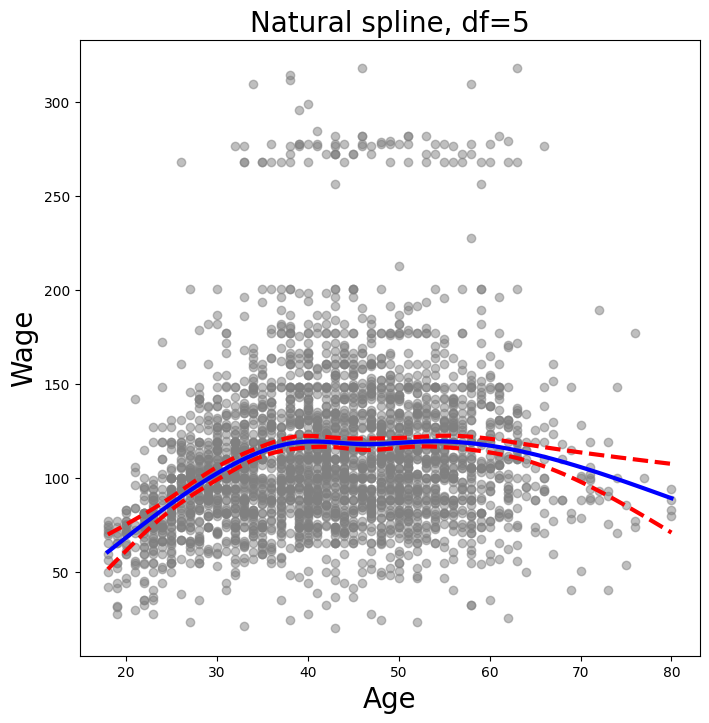

In [42]:
# 绘制自然样条曲线
plot_wage_fit(age_df, ns_age, 'Natural spline, df=5');

---
---

## **3. Smoothing Splines and GAMs**
**GAM：广义加性模型（Generalized Additive Models, GAM）**  
**光滑样条是具有平方误差损失和单个特征的GAM的特例。**

#### **Smoothing Spline Optimization**

为了确保$g$是平滑的，我们可以使用以下优化公式：

$$\sum_{i=1}^n (y_i - g(x_i))^2 + \lambda \int (g''(t))^2 dt$$

其中$\lambda$是一个非负的调优参数。

##### **解释**

上式表示类似于岭回归和拉索的“损失+惩罚”公式。以下是每个部分的含义：

- **损失函数**：术语$\sum_{i=1}^n(y_i-g(x_i))^2$是一个损失函数，它通过最小化观测值$y_i$和预测值$g(x-i)$之间的平方差来鼓励$g$很好地拟合数据。

- **惩罚项**：$\lambda \int(g''(t))^2 dt$是一个控制$g$平滑度的惩罚项。它通过考虑其二阶导数$(g''(t)$的平方积分来惩罚$g$的可变性。较大的$\lambda$值会对曲率施加更强的惩罚，从而得到更平滑的函数$g$。

#### **回归问题**
使用光滑的非线形函数$f_j(x_{ij})$代替$\beta_j x_{ij}$
即：
$$y=\beta_0+\beta_1f(X_1)+\beta_2f(X_2)+\dots+\beta_pf(X_p)+\varepsilon_i$$

其中，每个 $f(X_i)$ 都可以是一个非线性平滑函数，由 $s()$ 定义

**广义加性模型提供了一种对标准线性进行推广的框架**。这个框架中，每个变量用一个非线形函数替换，同时保持模型可加性。

#### **GAM 优点**
1. 允许每个$x_j$ 拟合非线性 $f_j$，自动对标准的线形回归模型所忽略的非线形关系建模；
2. 非线性模型将响应变量预测的更加精确；
3. 可分析单个自变量对于响应变量的影响效果分析效果和自由度分析。

#### **GAM 缺点**：
1.由于可加形式，会忽略有意义的交互项。但是可以增加$X_i * X_j$的交互项进行修正


想要摆脱上面的限定，可以采用随机森林和提升法之类更加光滑的方法。**GAM 可以被看作是线形模型和完全非参数模型之间一类折中的方法**。

#### **分类问题**
GAM logistic 模型：

$$log (\frac{p(X)}{1-p(X)} )=\beta_0+f(X_1)+f(X_2)+\dots +f(X_p)$$

左边是$P(Y = 1|X)$与$P(Y = 0|X)$的比值的对数。  
本实验的设定为：
$$log (\frac{p(X)}{1-p(X)} )=\beta_0+\beta_1*year+f_2(age)+f_3(education)$$

In [48]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (summarize, poly, ModelSpec as MS)

from statsmodels.stats.anova import anova_lm
from pygam import (s as s_gam, l as l_gam, f as f_gam, LinearGAM, LogisticGAM)
from ISLP.pygam import (approx_lam, degrees_of_freedom, plot as plot_gam, anova as anova_gam)

#### **pygam 是一个用于广义加性模型（Generalized Additive Models, GAM）的 Python 库**。  
- 为了在Python中应用GAM，我们将使用pygam包。pip install pygam
  
**(1). 从 pygam 导入了一些用于构造 GAM 模型的函数和类**：
- s：用于定义光滑样条（spline）基函数，通常用于平滑连续变量。
- l：用于定义线性效应。
- f：用于定义分类变量（factor）的 GAM 变换。
- LinearGAM：线性广义加性模型（Linear Generalized Additive Model）。
- LogisticGAM：逻辑回归广义加性模型（Logistic Generalized Additive Model）。

**(2). 从 ISLP.pygam 模块导入了一些与 GAM 相关的函数**：
- approx_lam：用于近似计算 GAM 模型的光滑参数 lambda。
- degrees_of_freedom：计算自由度。
- plot（重命名为 plot_gam）：用于绘制 GAM 结果。
- anova（重命名为 anova_gam）：用于进行方差分析（ANOVA），评估 GAM 模型中的变量是否显著。

In [50]:
# pygam库通常需要一个特征矩阵而不是向量
X_age = np.asarray(age).reshape((-1,1)) # reshape()方法调用中的-1告诉numpy根据形状元组的剩余条目来估算该维度的大小。
X_age

array([[18],
       [24],
       [45],
       ...,
       [27],
       [27],
       [55]], dtype=int64)

In [51]:
# 在 X_age上应用光滑样条。
gam = LinearGAM(s_gam(0, lam=0.6)) 
gam.fit(X_age, y) 

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + intercept, tol=0.0001, 
   verbose=False)

下面探究一下拟合如何随平滑参数lam而变化。
函数np.logspace（）类似于np.linspace。但空格在对数刻度上均匀指向。
下面我们将lam从$(0.01)$变为$(100,0000)$。

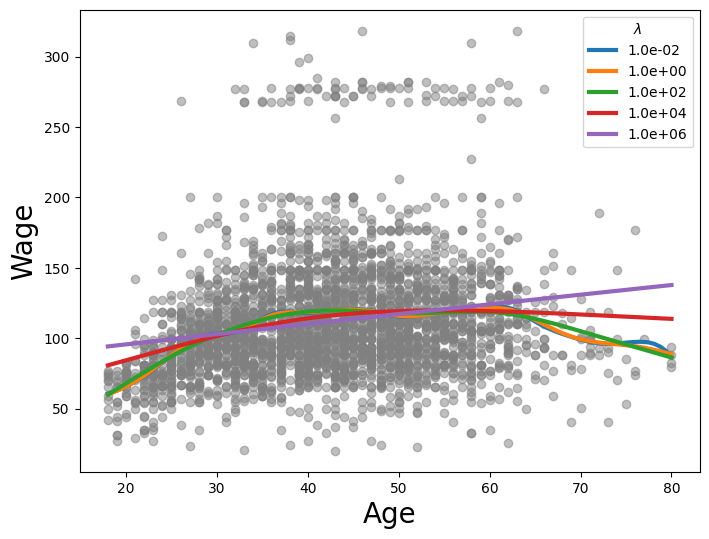

In [53]:
# 绘制不同平滑参数 λ 对 GAM 拟合结果的影响
fig, ax = subplots(figsize=(8,6))
ax.scatter(age, y, facecolor='gray', alpha=0.5) # 绘制原始数据点，每个点对应一名个体的年龄和工资
for lam in np.logspace(-2, 6, 5):
    gam = LinearGAM(s_gam(0, lam=lam)).fit(X_age, y)
    ax.plot(age_grid,           # 前面为我们想要预测的年龄值创建过一个网格。age_grid = np.linspace(age.min(), age.max(), 100)
            gam.predict(age_grid), label='{:.1e}'.format(lam), linewidth=3)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Wage', fontsize=20);
ax.legend(title='$\lambda$');

#### **解释**
- （蓝色） → $(0.01)$最灵活，紧密跟随数据点，有明显波动（可能过拟合）。
- （橙色） → 仍然有一定的曲线形态，但比 $(0.01)$平滑。
- （绿色） → 进一步平滑，仍然能捕捉非线性趋势。
- （红色） → 更加平滑，基本呈现接近线性的趋势。
- （紫色） → 近似一条直线，说明平滑度过高，模型欠拟合。

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00


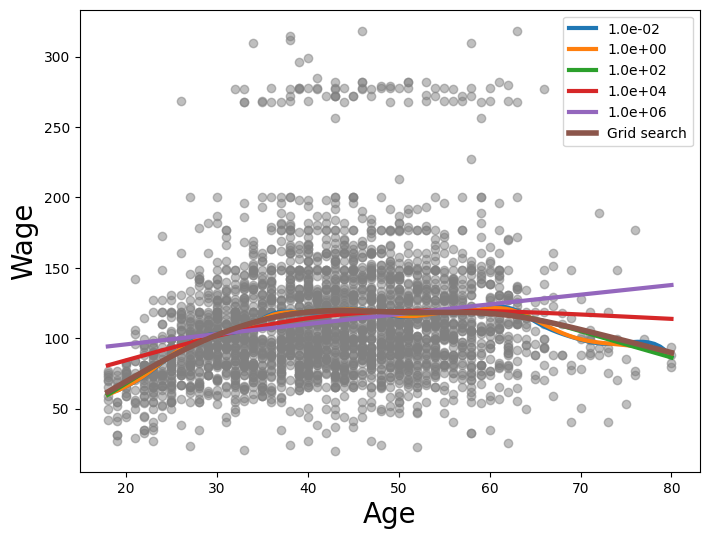

In [55]:
# pygam包可以搜索最佳光滑参数。
gam_opt = gam.gridsearch(X_age, y)
ax.plot(age_grid, gam_opt.predict(age_grid), label='Grid search', linewidth=4)
ax.legend()
fig

#### **或者，我们可以使用ISLP.pygam包中包含的函数来固定光滑样条的自由度**。
- 下面我们找到一个值，它给了我们大约四个自由度。
- 在这里，这些自由度包括平滑样条的未罚截距和线性项，因此**至少有两个**自由度。

In [57]:
age_term = gam.terms[0]
lam_4 = approx_lam(X_age, age_term, 4) # 反向估计合适的 λ，使 X_age 的splins具有 4 个自由度
age_term.lam = lam_4
degrees_of_freedom(X_age, age_term) # 计算 X_age 变量的最终自由度，确认其是否接近 4

4.0000001000025565

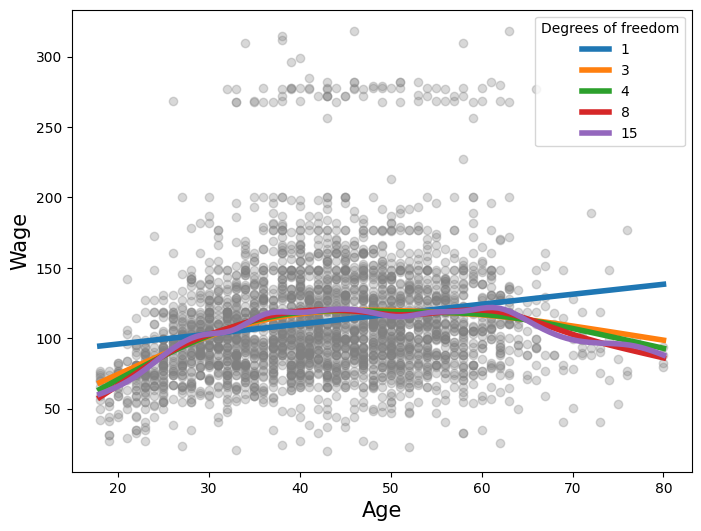

In [58]:
# 迭代不同的自由度 df，观察它们对 GAM 拟合曲线的影响。
fig, ax = subplots(figsize=(8,6))
ax.scatter(X_age, y,  facecolor='gray', alpha=0.3)
for df in [1,3,4,8,15]:
    # 选择df+1作为所需的自由度，以解释splines总是有截距项。
    lam = approx_lam(X_age, age_term, df+1)
    age_term.lam = lam
    gam.fit(X_age, y)
    ax.plot(age_grid, gam.predict(age_grid), label='{:d}'.format(df), linewidth=4)
    # 因此，df的值为1只是线性拟合。
ax.set_xlabel('Age', fontsize=15)
ax.set_ylabel('Wage', fontsize=15);
ax.legend(title='Degrees of freedom');

#### **结果**
- df=1（线性拟合）：曲线接近直线。
- df=3（中等平滑）：曲线稍微弯曲。
- df=4（较高平滑）：曲线能捕捉一定非线性趋势。
- df=8（高自由度）：曲线更加灵活，捕捉数据波动。
- df=15（极高自由度）：曲线可能过拟合，过于复杂。

## **具有多个变量的加性模型**
#### 广义加性模型的优势在于它们能够比线性模型**更灵活地拟合多元回归模型**。
- 使用两种方法：
    - 第一种方法使用**自然样条和分段常数函数**，以更手动的方式进行；
    - 第二种方法使用**pygam包和平滑样条**。

#### **（1）对 age、year 变量使用自然样条（Natural Spline）进行建模**。 

In [62]:
ns_age = NaturalSpline(df=4).fit(age)
ns_year = NaturalSpline(df=5).fit(Wage['year'])

In [63]:
# 将 age/year 转换为 4/5 维自然样条基函数。  
# 生成 education 变量的哑变量矩阵（每种教育水平变成单独一列）。
Xs = [ns_age.transform(age), ns_year.transform(Wage['year']), pd.get_dummies(Wage['education']).values]
Xs

[      NaturalSpline(df=4)[0]  NaturalSpline(df=4)[1]  NaturalSpline(df=4)[2]  \
 0                   0.000000                0.000000                0.000000   
 1                   0.017316               -0.137954                0.318722   
 2                   0.751086                0.166050                0.091316   
 3                   0.780172                0.072225                0.110026   
 4                   0.529332                0.388794                0.137083   
 ...                      ...                     ...                     ...   
 2995                0.772273                0.118523                0.096815   
 2996                0.138528               -0.213620                0.493536   
 2997                0.058442               -0.187466                0.433111   
 2998                0.058442               -0.187466                0.433111   
 2999                0.306568                0.511568                0.207108   
 
       NaturalSpline(df=4)

In [64]:
# 将三个分量矩阵水平堆叠，形成模型矩阵X_bh。
X_bh = np.hstack(Xs)
X_bh

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.01731602, -0.13795411,  0.31872157, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.7510856 ,  0.16605047,  0.09131609, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 0.05844156, -0.18746615,  0.43311146, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.05844156, -0.18746615,  0.43311146, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.30656791,  0.51156808,  0.20710768, ...,  0.        ,
         0.        ,  0.        ]])

X_bh 现在是一个 N × (4 + 5 + k) 的矩阵，其中：  
- 4 列： age 的样条转换结果。
- 5 列： year 的样条转换结果。
- k 列： education 的哑变量。

In [66]:
gam_bh = sm.OLS(y, X_bh).fit()

#### **现在展示如何为GAM中的每个变量构建部分依赖图**。

In [68]:
age_grid = np.linspace(age.min(), age.max(), 100)
X_age_bh = X_bh.copy()[:100]
# 除了 age 变量之外的所有变量都被固定在其均值，这样可以观察 age 对 wage 的单独影响。
X_age_bh[:] = X_bh[:].mean(0)[None,:]
# X_age_bh 只有 age 变量是变化的，其他变量保持均值。
X_age_bh[:,:4] = ns_age.transform(age_grid)

#### **构建思路**
- 创建一个新的预测矩阵，其中除了属于年龄的列之外，所有列都是常数（并设置为它们的训练数据均值）
- 年龄的四列用自然样条基填充，在age_grid中以100个值进行评估。

**实施步骤**  
1. 制作了一个长度为100的网格，并创建了一个矩阵X_age_bh，其中包含100行，列数与X_bh相同。  
2. 用原始矩阵的列均值替换了该矩阵的每一行。  
3. 然后，仅将表示年龄的前四列替换为根据age_grid中的值计算的自然样条基。

In [70]:
# 只需使用新的X矩阵进行预测，一次固定除一个特征外的所有特征。
# 由于X只改变age，其预测结果代表了在 year 和 education 固定时，age 变量对 wage 的影响。
preds = gam_bh.get_prediction(X_age_bh)
bounds_age = preds.conf_int(alpha=0.05)
# 取预测的均值（age的部分效应）。
partial_age = preds.predicted_mean
center = partial_age.mean()
center

107.84421866955559

#### **去中心化**：
- 计算 partial_age 的均值，并将所有预测值减去这个均值。
- 这样，偏效应曲线以均值为基准，展示 age 对 wage 的偏离影响。
- 这样做的好处是，使得 wage 的波动模式更直观，易于比较不同变量的贡献。

In [72]:
partial_age-= center
partial_age

array([-33.49112025, -31.88432078, -30.27938613, -28.6781811 ,
       -27.08257052, -25.4944192 , -23.91559195, -22.34795359,
       -20.79336893, -19.25370279, -17.73081999, -16.22658533,
       -14.74286363, -13.2815197 , -11.84441837, -10.43342445,
        -9.05040274,  -7.69721807,  -6.37573525,  -5.08781909,
        -3.83533442,  -2.62014603,  -1.44411876,  -0.30911741,
         0.78299321,   1.83034827,   2.83113269,   3.7838444 ,
         4.6871028 ,   5.53952756,   6.33973834,   7.08635482,
         7.77799667,   8.41328354,   8.99083512,   9.50927108,
         9.96721107,  10.36327477,  10.69608184,  10.9645339 ,
        11.17068529,  11.31856676,  11.41223948,  11.45576462,
        11.45320337,  11.40861689,  11.32606637,  11.20961297,
        11.06331788,  10.89124227,  10.69744732,  10.4859942 ,
        10.26094409,  10.02633937,   9.7848422 ,   9.5368154 ,
         9.28240408,   9.02175335,   8.75500829,   8.48231403,
         8.20381565,   7.91965827,   7.62998698,   7.33

In [73]:
bounds_age-= center
bounds_age

array([[-4.08912736e+01, -2.60909669e+01],
       [-3.87843275e+01, -2.49843141e+01],
       [-3.66876810e+01, -2.38710913e+01],
       [-3.46062193e+01, -2.27501429e+01],
       [-3.25450935e+01, -2.16200476e+01],
       [-3.05097804e+01, -2.04790580e+01],
       [-2.85061473e+01, -1.93250366e+01],
       [-2.65405056e+01, -1.81554016e+01],
       [-2.46196266e+01, -1.69671112e+01],
       [-2.27506629e+01, -1.57567427e+01],
       [-2.09408893e+01, -1.45207506e+01],
       [-1.91971600e+01, -1.32560106e+01],
       [-1.75250252e+01, -1.19607020e+01],
       [-1.59276219e+01, -1.06354175e+01],
       [-1.44047127e+01, -9.28412400e+00],
       [-1.29523854e+01, -7.91446348e+00],
       [-1.15636843e+01, -6.53712122e+00],
       [-1.02299313e+01, -5.16450483e+00],
       [-8.94215941e+00, -3.80931109e+00],
       [-7.69218712e+00, -2.48345107e+00],
       [-6.47319868e+00, -1.19747015e+00],
       [-5.27994072e+00,  3.96486555e-02],
       [-4.10872068e+00,  1.22048316e+00],
       [-2.

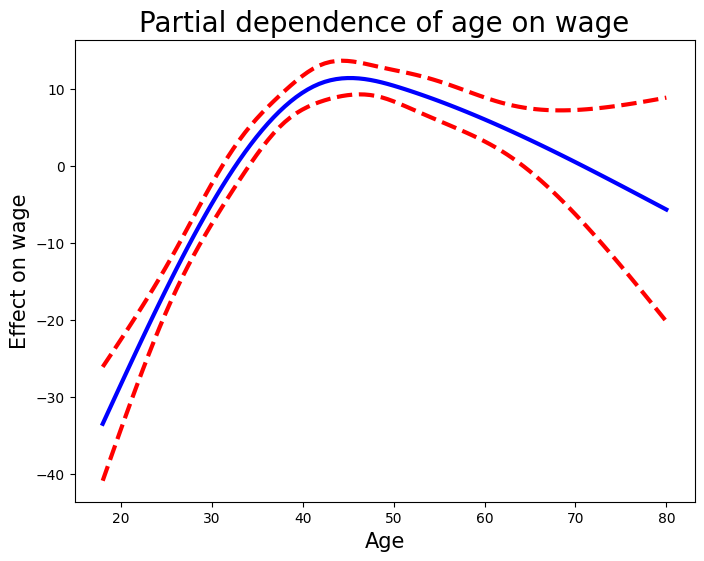

In [74]:
# 绘制图片
fig, ax = subplots(figsize=(8,6))
ax.plot(age_grid, partial_age, 'b', linewidth=3)
ax.plot(age_grid, bounds_age[:,0], 'r--', linewidth=3)
ax.plot(age_grid, bounds_age[:,1], 'r--', linewidth=3)
ax.set_xlabel('Age', fontsize=15)
ax.set_ylabel('Effect on wage', fontsize=15)
ax.set_title('Partial dependence of age on wage', fontsize=20);

In [75]:
# 余下步骤：关注影响工资的因素；过程是一样的。
year_grid = np.linspace(2003, 2009, 100)
year_grid = np.linspace(Wage['year'].min(), Wage['year'].max(), 100)
X_year_bh = X_bh.copy()[:100]
X_year_bh[:] = X_bh[:].mean(0)[None,:]
X_year_bh[:,4:9] = ns_year.transform(year_grid)
preds = gam_bh.get_prediction(X_year_bh)
bounds_year = preds.conf_int(alpha=0.05)
partial_year = preds.predicted_mean
center = partial_year.mean()
partial_year-= center
bounds_year-= center

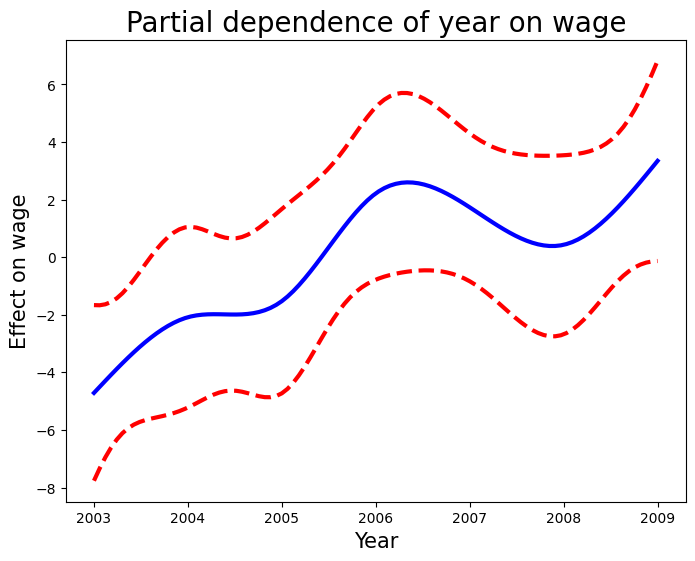

In [76]:
fig, ax = subplots(figsize=(8,6))
ax.plot(year_grid, partial_year, 'b', linewidth=3)
ax.plot(year_grid, bounds_year[:,0], 'r--', linewidth=3)
ax.plot(year_grid, bounds_year[:,1], 'r--', linewidth=3)
ax.set_xlabel('Year', fontsize=15)
ax.set_ylabel('Effect on wage', fontsize=15)
ax.set_title('Partial dependence of year on wage', fontsize=20);

### **(2). 我们现在使用平滑样条而不是自然样条来构建模型**。

In [78]:
# 由于year只有7个唯一值，因此使用了7个基函数。
gam_full = LinearGAM(s_gam(0) + s_gam(1, n_splines=7) + f_gam(2, lam=0))
# pygam包仅适用于矩阵，必须将分类序列edu转换为数组表示，通过cat.codes实现。
Xgam = np.column_stack([age, Wage['year'], Wage['education'].cat.codes])
gam_full = gam_full.fit(Xgam, y)

- 这两个s_gam()实现平滑样条拟合，并使用默认值（lam=0.6），这有点任意。  
- 对于分类项education，专门使用f_gam()术语，指定lam=0，不对其平滑处理。


**解释**
1. NS 方法 是手动定义自由度的自然样条，更具可控性。  
2. GAM 方法 通过 s_gam() 自动选择平滑程度，让 age 和 year 更灵活地拟合数据趋势。

**这种方法特别适用于**：  
(1). 非线性关系较强 的数据（如 age 对 wage 的影响可能是非线性的）。  
(2). 具有分类变量 的数据（education 作为因子变量）。

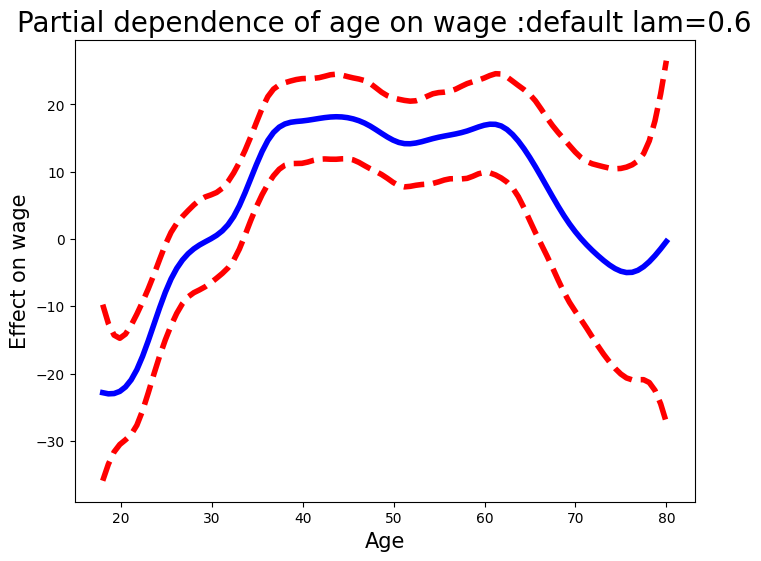

In [80]:
# 绘图值由pygam包生成。
# 我们为ISLP.pygam中的部分依赖图提供了plot_gam()函数
fig, ax = subplots(figsize=(8,6))
plot_gam(gam_full, 0, ax=ax)
ax.set_xlabel('Age', fontsize=15)
ax.set_ylabel('Effect on wage', fontsize=15)
ax.set_title('Partial dependence of age on wage :default lam=0.6', fontsize=20);

- 可以看到函数有点摆动。或许指定df比指定lam的值更自然。
- 使用四个自由度对GAM进行重新拟合，age和year各自四个基函数。
- 下面添加一个考虑了平滑样条的截距。

In [82]:
# 提取 age 对应的项（s_gam(0)）
age_term = gam_full.terms[0]
# 计算 age 的 λ（平滑惩罚参数）， df = 4+1（因为样条包含截距）
age_term.lam = approx_lam(Xgam, age_term, df=4+1)
# 对于year_term.lam也是如此。
year_term = gam_full.terms[1]
year_term.lam = approx_lam(Xgam, year_term, df=4+1)
# 重新拟合模型
gam_full = gam_full.fit(Xgam, y)

Text(0.5, 1.0, 'Partial dependence of age on wage')

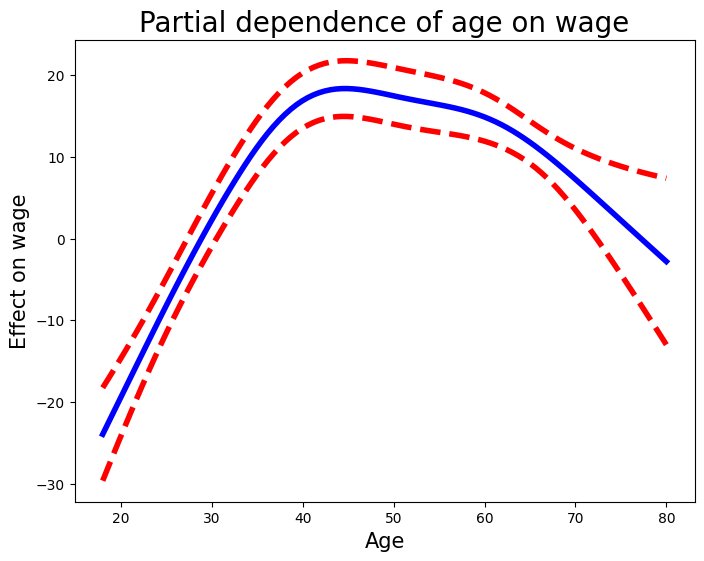

In [83]:
# 重复age的曲线，它要平滑得多。下面还绘制了year的图。
fig, ax = subplots(figsize=(8,6))
plot_gam(gam_full, 0, ax=ax)
ax.set_xlabel('Age', fontsize=15)
ax.set_ylabel('Effect on wage', fontsize=15)
ax.set_title('Partial dependence of age on wage', fontsize=20)

Text(0.5, 1.0, 'Partial dependence of year on wage')

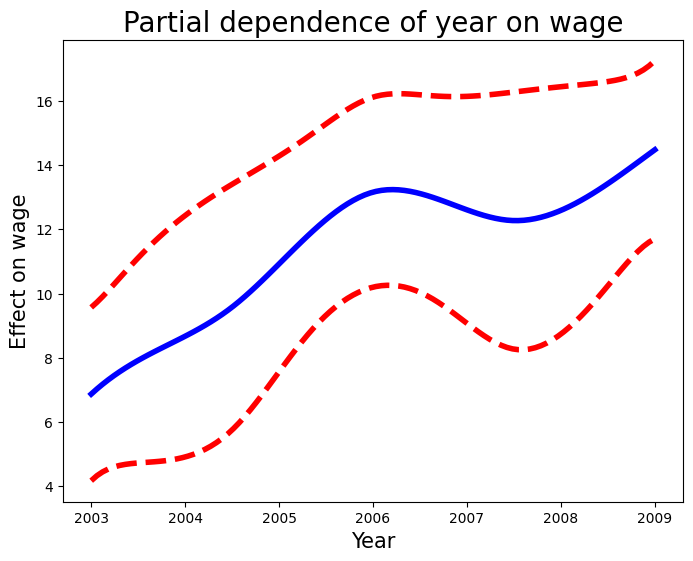

In [84]:
fig, ax = subplots(figsize=(8,6))
plot_gam(gam_full, 1, ax=ax)
ax.set_xlabel('Year', fontsize=15)
ax.set_ylabel('Effect on wage', fontsize=15)
ax.set_title('Partial dependence of year on wage', fontsize=20)

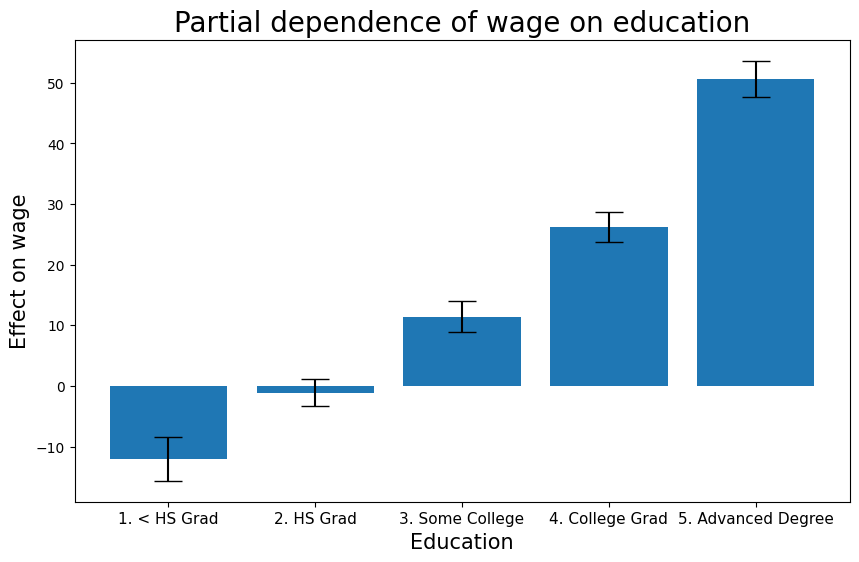

In [85]:
# 最后，对education进行了分类。
fig, ax = subplots(figsize=(10, 6))
ax = plot_gam(gam_full, 2)
ax.set_xlabel('Education', fontsize=15)
ax.set_ylabel('Effect on wage', fontsize=15)
# 图是不同的，更适合于该变量每个级别的拟合常数集。
ax.set_title('Partial dependence of wage on education', fontsize=20);
ax.set_xticklabels(Wage['education'].cat.categories, fontsize=11);

**解释**
- 每个柱状图上方的黑色线条表示 置信区间（Confidence Interval, CI），通常是 95% 置信区间。
- 置信区间较窄（如 HS Grad、College Grad），表示估计较精确。
- 置信区间较宽（如 < HS Grad），说明该组数据可能更不稳定，或者样本较少。

### **ANOVA(方差分析) Tests for Additive Models**
- 在所有的模型中，*year*的函数看起来都是线性的。
- 我们可以执行一系列anova测试，以确定这三个模型中哪一个最好：  
    (1) $(M_1)$：不包括 year 的GAM；   
    (2) $(M_2)$：使用 year 线性函数的GAM；    
    (3) $(M_3)$：使用 year 样条函数的GAM。  

In [88]:
# 使用了age_term。因为前面为这个项中的lam设定了值，以实现四个自由度。
gam_0 = LinearGAM(age_term + f_gam(2, lam=0))
gam_0.fit(Xgam, y)

gam_linear = LinearGAM(age_term + l_gam(1, lam=0) + f_gam(2, lam=0))
gam_linear.fit(Xgam, y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + l(1) + f(2) + intercept, 
   tol=0.0001, verbose=False)

In [89]:
anova_gam(gam_0, gam_linear, gam_full)

,deviance,df,deviance_diff,df_diff,F,pvalue
0,3.714362e+06,2991.004005,NaN,NaN,NaN,NaN
1,3.696746e+06,2990.005190,17616.542840,0.998815,14.265131,0.002314
2,3.693143e+06,2987.007254,3602.893655,2.997936,0.972007,0.435579


**结果表明，使用 $(M_2)$ 线性函数的GAM比根本不包括 $(M_1)$ 的GAM更好（$p$值=0.002）**。  
- 然而，$(M_3)$的结果（$p$值=0.435）说明非线性函数不是必须的。
- 也就是说，根据方差分析的结果，$M_2$线性函数的GAM是首选。

In [91]:
# 也可以对age重复同样的过程。
gam_0 = LinearGAM(year_term + f_gam(2, lam=0))
gam_linear = LinearGAM(l_gam(0, lam=0) + year_term + f_gam(2, lam=0))

gam_0.fit(Xgam, y)
gam_linear.fit(Xgam, y)

# 有非常明确的证据表明，age需要一个非线性项。
anova_gam(gam_0, gam_linear, gam_full)

,deviance,df,deviance_diff,df_diff,F,pvalue
0,3.975443e+06,2991.000589,NaN,NaN,NaN,NaN
1,3.850247e+06,2990.000704,125196.137317,0.999884,101.270106,1.681120e-07
2,3.693143e+06,2987.007254,157103.978302,2.993450,42.447812,5.669414e-07


In [92]:
# GAM拟合有一个（详细verbose）summary()方法。
gam_full.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     12.9927
Link Function:                     IdentityLink Log Likelihood:                                 -24117.907
Number of Samples:                         3000 AIC:                                            48263.7995
                                                AICc:                                             48263.94
                                                GCV:                                             1246.1129
                                                Scale:                                           1236.4024
                                                Pseudo R-Squared:                                   0.2928
Feature Function                  Lam

#### 我们可以使用gam类的predict()方法从gam对象中进行预测，就像从lm对象中一样。在这里，我们对训练集进行预测。

In [94]:
Yhat = gam_full.predict(Xgam)

In [95]:
# 为了拟合逻辑回归GAM，使用pygam中的LogisticGAM()。
gam_logit = LogisticGAM(age_term + l_gam(1, lam=0) + f_gam(2, lam=0))
gam_logit.fit(Xgam, high_earn)

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + l(1) + f(2) + intercept, tol=0.0001, verbose=False)

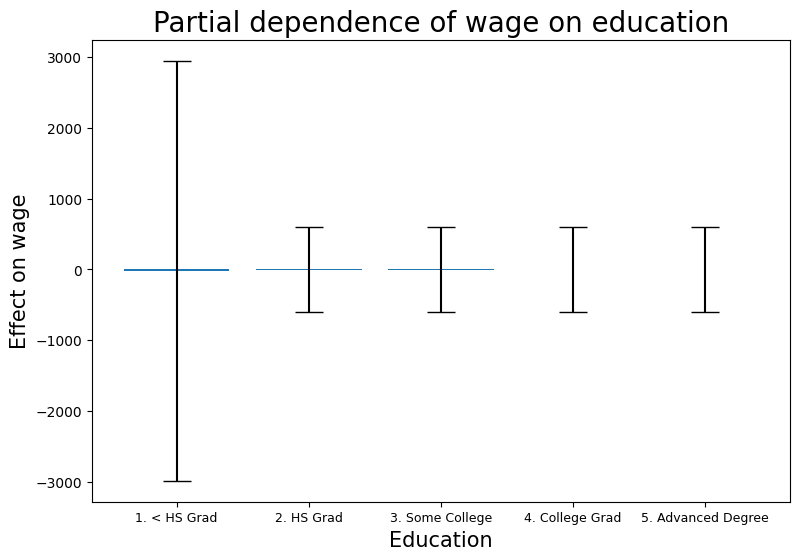

In [96]:
fig, ax = subplots(figsize=(9, 6))
ax = plot_gam(gam_logit, 2)
ax.set_xlabel('Education', fontsize=15)
ax.set_ylabel('Effect on wage', fontsize=15)
ax.set_title('Partial dependence of wage on education', fontsize=20);
ax.set_xticklabels(Wage['education'].cat.categories, fontsize=9);

In [97]:
# 该模型似乎非常平坦，第一类的误差条特别高。需要更仔细地看看数据。
pd.crosstab(Wage['high_earn'], Wage['education'])

education,1. < HS Grad,2. HS Grad,3. Some College,4. College Grad,5. Advanced Degree
high_earn,,,,,
False,268,966,643,663,381
True,0,5,7,22,45


在第一类*education*中没有高收入者，这意味着这种模式将很难适应。  
下面拟合一个逻辑回归GAM，排除所有属于这一类别的观测值。这提供了更合理的结果。

In [99]:
# 可以对模型矩阵进行子集划分，不会从Xgam中删除该列。
only_hs = Wage['education'] == '1. < HS Grad'
Wage_ = Wage.loc[~only_hs]
# 虽然可以推断出哪个列对应于这个特征，但为了可重复性，在这个较小的子集上对模型矩阵进行了更改。
Xgam_ = np.column_stack([Wage_['age'],
                         Wage_['year'],
                         Wage_['education']
                         .cat.codes-1])
high_earn_ = Wage_['high_earn']

在上面的操作中，由于pygam中的一个错误，从类别的代码中减去一。  
它只是重新标记了*education*的值，因此对拟合度没有影响。

In [101]:
# 拟合模型
gam_logit_ = LogisticGAM(age_term + year_term + f_gam(2, lam=0))
gam_logit_.fit(Xgam_, high_earn_)

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + s(1) + f(2) + intercept, tol=0.0001, verbose=False)

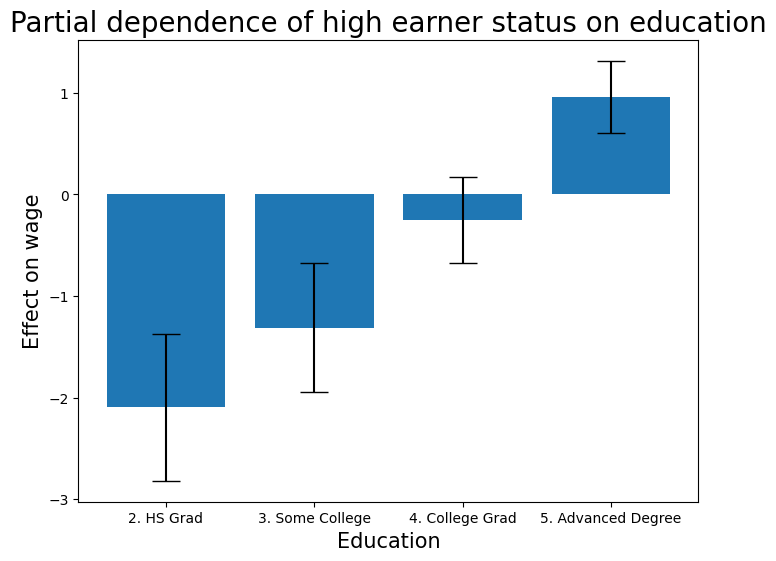

In [102]:
# 教育、年龄和年龄对高收入者地位的影响。
fig, ax = subplots(figsize=(8, 6))
ax = plot_gam(gam_logit_, 2)
ax.set_xlabel('Education', fontsize=15)
ax.set_ylabel('Effect on wage', fontsize=15)
ax.set_title('Partial dependence of high earner status on education', fontsize=20);
ax.set_xticklabels(Wage['education'].cat.categories[1:], fontsize=10);

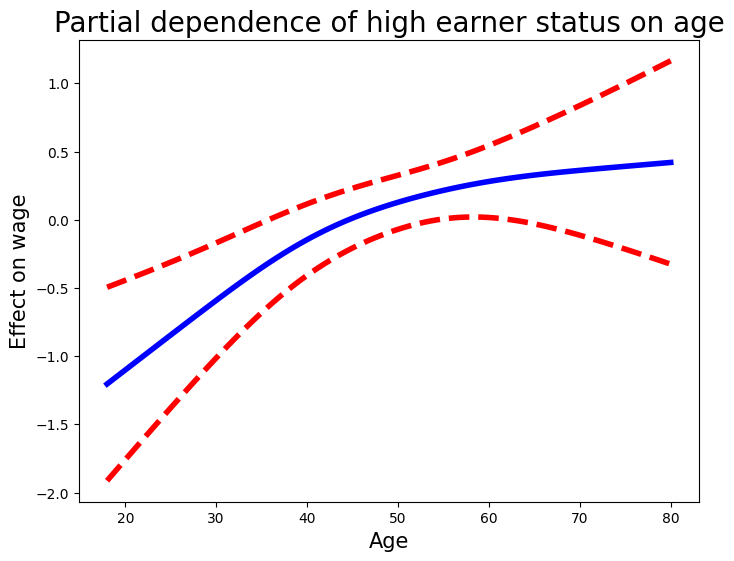

In [103]:
fig, ax = subplots(figsize=(8, 6))
ax = plot_gam(gam_logit_, 0)
ax.set_xlabel('Age', fontsize=15)
ax.set_ylabel('Effect on wage', fontsize=15)
ax.set_title('Partial dependence of high earner status on age', fontsize=20);

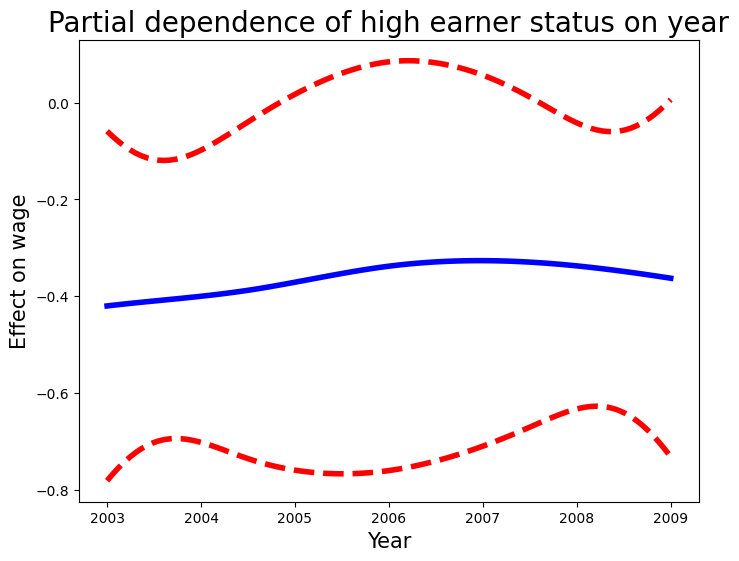

In [104]:
fig, ax = subplots(figsize=(8, 6))
ax = plot_gam(gam_logit_, 1)
ax.set_xlabel('Year', fontsize=15)
ax.set_ylabel('Effect on wage', fontsize=15)
ax.set_title('Partial dependence of high earner status on year', fontsize=20);

**解释**  
1. 上下置信区间（Confidence Interval, CI）较宽：
- 可能某些年份的数据较少，导致该年份的估计不稳定。
- 数据的变异性较大，不同年份的收入状况可能受经济周期、政策等因素影响。
- 平滑样条可能在 边界（如最早或最晚年份）产生外推问题，导致不确定性增加。

2. 上下界线（置信区间）存在抖动，而预测曲线相对平稳
- 预测曲线平稳是因为 GAM 强制对 year 变量使用平滑样条，避免了过拟合噪声数据。
- 置信区间的 抖动 可能由以下因素造成：
    - 样本量不均衡：某些年份的数据点较少，导致该年的置信区间估计波动较大。
    - 数据噪声：即使 year 被平滑建模，但误差的估计仍然依赖于 局部数据分布，某些年份的不确定性更高，导致置信区间抖动。
    - logistic GAM 的非线性特性：由于是在逻辑回归框架下建模，模型的偏差-方差权衡可能会在某些数据点附近产生较大方差。

---
---

## **4. Local Regression**
#### 局部回归是拟合光滑非线性函数的另一种方法。该方法只用到这个点附近的训练观测.
1. 使用sm.nonparameter中的lowess()函数说明了局部回归的使用。
2. GAM的一些实现允许术语是局部回归运算符；pygam的情况并非如此。
3. 在这里，我们使用0.2和0.5的跨度来拟合局部线性回归模型：
    - 也就是说，每个邻域由20%或50%的观测值组成。
    - 正如预期的那样，使用0.5的跨度比0.2更平滑。

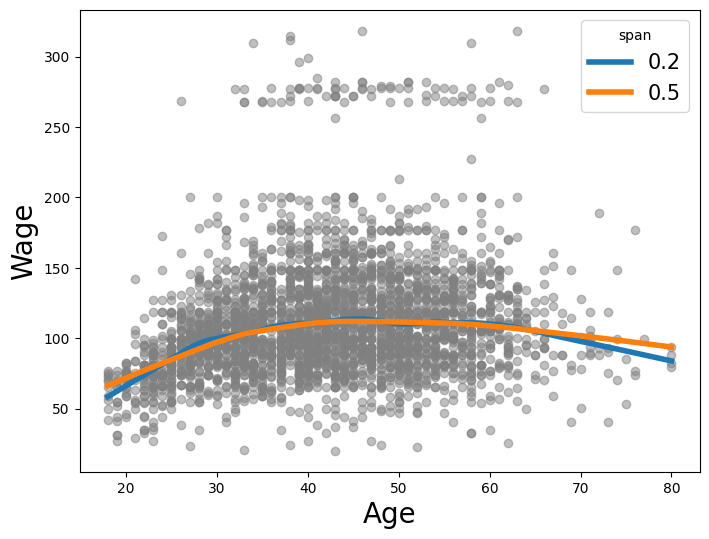

In [108]:
# 调用 LOWESS 局部回归方法
lowess = sm.nonparametric.lowess
fig, ax = subplots(figsize=(8,6))
ax.scatter(age, y, facecolor='gray', alpha=0.5)
# 遍历两个不同的平滑参数
for span in [0.2, 0.5]:
    fitted = lowess(y, 
                    age, 
                    frac=span, # 设置跨度（局部回归的窗口大小）
                    xvals=age_grid)  # 计算平滑拟合值
    ax.plot(age_grid, fitted, label='{:.1f}'.format(span), linewidth=4)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Wage', fontsize=20);
ax.legend(title='span', fontsize=15);

1. **lowess() 方法用于 局部加权回归（LOWESS），它是一种 非参数回归方法，用于拟合平滑的非线性关系**
- frac=span: 平滑参数，表示每个点的回归 窗口大小（即使用多少比例的数据点进行局部拟合）。
- xvals=age_grid: 计算回归曲线的点。  


2. **span 控制平滑程度**
- span=0.2：每个点的回归仅使用 20% 的数据点 ➝ 更灵活，拟合曲线更细致，可能会有些震荡。
    - 蓝色曲线（span=0.2）：更灵活（更“跟随”数据的波动），适合捕捉局部趋势。但可能会受到噪声影响，出现波动。

- span=0.5：每个点的回归使用 50% 的数据点 ➝ 曲线更平滑，但可能会忽略一些局部波动。
    - 橙色曲线（span=0.5）：更平滑，忽略小的波动，适合整体趋势分析。但可能会丢失某些微小的模式（如中年收入峰值）。

---
---

## **朴素贝叶斯算法实操**
**这里利用sklearn库直接实现三种贝叶斯算法**：
1. 高斯朴素贝叶斯
2. 多项分布朴素贝叶斯
3. 伯努利朴素贝叶斯
采用的数据集为**鸢尾花(iris)数据集**。

### **1. 高斯朴素贝叶斯**
常用参数：  
- $alpha$：先验平滑因子，默认等于1，当等于1时表示普拉斯平滑；  
- *fit_prior*：是否去学习类的先验概率，默认是*True*；  
- *class_prior*：各个类别的先验概率，如果没有指定，则模型会根据数据自动学习，每个类别的先验概率相同，等于类标记总个数的$(1/N)$。

In [112]:
# 高斯朴素贝叶斯
from sklearn import datasets
from sklearn.model_selection import train_test_split
iris = datasets.load_iris()

In [113]:
# 加载完Iris数据集后，先利用Sklearn中的train_test_split
from sklearn.naive_bayes import GaussianNB
x = iris.data   # 特征
y = iris.target # 标签
# 将样本分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state = 42)
# 然后按照使用机器学习三步走的方式，先声明GaussianNB类。
clf = GaussianNB()
# 然后调用fit方法拟合数据
clf.fit(X_train, y_train)
# 最后调用score方法评价。
score = clf.score( X_test,  y_test)
print(f"模型准确率: {score:.4f}")

模型准确率: 0.9778


### **2. 伯努利朴素贝叶斯**
**操作过程与高斯朴素贝叶斯一致，只是常用参数不同**。  
常用参数：  
- $alpha$：平滑因子；  
- *binarize*：是样本特征二值化的阈值，默认是0，如果不输入，则模型会认为所有特征都已经是二值化形式;  
    - 若输入具体值，则模型会把大于该值的部分归为一类，小于该值的部分归为二类；  
- *fit_prior*：是否去学习类的先验概率，默认是*True*；  
- *class_prior*，各个类别的先验概率，如果没有指定，则模型会根据数据自动学习，每个类别的先验概率相同，等于类标记总个数的$(1/N)$。

In [115]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
iris = datasets.load_iris()

In [116]:
from sklearn.naive_bayes import BernoulliNB
X = iris.data  # 特征
y = iris.target  # 标签

# 将样本分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
# 对特征进行二值化处理，以每个特征的中位数为阈值
binarize_thresholds = np.median(X_train, axis=0)

# 将训练集和测试集的特征二值化
X_train_bin = np.where(X_train > binarize_thresholds, 1, 0)
X_test_bin = np.where(X_test > binarize_thresholds, 1, 0)

# 创建伯努利朴素贝叶斯分类器
clf = BernoulliNB(alpha=1.0, fit_prior=True)

# 训练模型
clf.fit(X_train_bin, y_train)

# 评估模型
score = clf.score(X_test_bin, y_test)
print(f"模型准确率: {score:.2f}")

模型准确率: 0.69


- 特征二值化：使用训练集每个特征的中位数作为阈值，将特征值大于阈值的部分设为1，小于等于阈值的部分设为0。这样可以确保特征符合伯努利朴素贝叶斯的假设。
- 随机种子：设置 random_state=42 以确保结果可重复。
- 模型参数：使用默认的 alpha=1.0（平滑因子）和 fit_prior=True（学习类的先验概率）。

### **3. 多项式朴素贝叶斯** 
常用参数：  
- $alpha$：浮点型可选参数，默认为1.0，其实就是添加拉普拉斯平滑，如果设置为0，就是不添加平滑；  
- *fit_prior*：是布尔型可选参数，默认是*True*，布尔参数*fit_prior*表示是否要考虑先验概率；
    - 如果是*false*，则所有的样本类别输出都有相同的类别先验概率，否则可以自己用第三个参数*class_prior*输入先验概率，
    - 或者不输入第3个参数，让MultinomialNB自己从训练样本来计算先验概率；  
- *class_prior*： 可选参数，默认为*None*。

In [119]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
iris = datasets.load_iris()

In [120]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
x = iris.data   # 特征
y = iris.target # 标签
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state = 42)
# 然后按照使用机器学习三步走的方式，先声明GaussianNB类。
# 然后调用fit方法拟合数据
clf.fit(X_train, y_train)
# 最后调用score方法评价。
score = clf.score(X_test, y_test)
print(f"模型准确率: {score:.4f}")

模型准确率: 0.9556


## **朴素贝叶斯分类**
### **案例：P2P平台个人信用评估**
### 背景介绍
- 本案例使用经典的 “prosperLoanData.csv”数据集，利用朴素贝叶斯模型，对用户是否能正常偿还贷款进行预测。
- 本案例将数据集中的收入以及信用额度数据与贷款状态（是否正常偿还）建立联系，希望通过借款人相关信息评估其个人信用。
    - 即：使用这些信息来预测借款人能否正常偿还借款。  

美国P2P网贷平台是一个通过让有借款需求者和有闲置资金的出资人能够自行配对的平台站点，目前拥有超98万会员，超过2亿美元的借贷额，是世界上最大的P2P借贷平台。

### **1. 数据读取与划分**
首先读取数据并对数据集进行初步了解

In [123]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
#base = pd.read_csv('D:/zhaoweihao/18_ML/prosperLoanData.csv')
base = pd.read_csv('E:/Replications/prosperLoanData.csv')

In [124]:
#base['ListingCreationDate'] = pd.to_datetime(base['ListingCreationDate'], format='ISO8601')
#base['ListingCreationDate'] = base['ListingCreationDate'].dt.date
base

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
0,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263000000,C,36,Completed,2009-08-14 00:00:00,0.16516,0.1580,0.1380,...,-133.18,0.0,0.0,0.0,0.0,1.0,0,0,0.0,258
1,10273602499503308B223C1,1209647,2014-02-27 08:28:07.900000000,NaN,36,Current,NaN,0.12016,0.0920,0.0820,...,0.00,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
2,0EE9337825851032864889A,81716,2007-01-05 15:00:47.090000000,HR,36,Completed,2009-12-17 00:00:00,0.28269,0.2750,0.2400,...,-24.20,0.0,0.0,0.0,0.0,1.0,0,0,0.0,41
3,0EF5356002482715299901A,658116,2012-10-22 11:02:35.010000000,NaN,36,Current,NaN,0.12528,0.0974,0.0874,...,-108.01,0.0,0.0,0.0,0.0,1.0,0,0,0.0,158
4,0F023589499656230C5E3E2,909464,2013-09-14 18:38:39.097000000,NaN,36,Current,NaN,0.24614,0.2085,0.1985,...,-60.27,0.0,0.0,0.0,0.0,1.0,0,0,0.0,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113932,E6D9357655724827169606C,753087,2013-04-14 05:55:02.663000000,NaN,36,Current,NaN,0.22354,0.1864,0.1764,...,-75.58,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
113933,E6DB353036033497292EE43,537216,2011-11-03 20:42:55.333000000,NaN,36,FinalPaymentInProgress,NaN,0.13220,0.1110,0.1010,...,-30.05,0.0,0.0,0.0,0.0,1.0,0,0,0.0,22
113934,E6E13596170052029692BB1,1069178,2013-12-13 05:49:12.703000000,NaN,60,Current,NaN,0.23984,0.2150,0.2050,...,-16.91,0.0,0.0,0.0,0.0,1.0,0,0,0.0,119
113935,E6EB3531504622671970D9E,539056,2011-11-14 13:18:26.597000000,NaN,60,Completed,2013-08-13 00:00:00,0.28408,0.2605,0.2505,...,-235.05,0.0,0.0,0.0,0.0,1.0,0,0,0.0,274


数据集中共有113937条数据，包括81个字段。这些字段的类型比较复杂，因此我们需要选择部分字段来研究，并选择2008年以后的数据。

In [126]:
drop = base
df_all = drop[drop['ListingCreationDate']>'2008-1-1']
df_all.reset_index(drop=True)
df_all

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
1,10273602499503308B223C1,1209647,2014-02-27 08:28:07.900000000,NaN,36,Current,NaN,0.12016,0.0920,0.0820,...,0.00,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
3,0EF5356002482715299901A,658116,2012-10-22 11:02:35.010000000,NaN,36,Current,NaN,0.12528,0.0974,0.0874,...,-108.01,0.0,0.0,0.0,0.0,1.0,0,0,0.0,158
4,0F023589499656230C5E3E2,909464,2013-09-14 18:38:39.097000000,NaN,36,Current,NaN,0.24614,0.2085,0.1985,...,-60.27,0.0,0.0,0.0,0.0,1.0,0,0,0.0,20
5,0F05359734824199381F61D,1074836,2013-12-14 08:26:37.093000000,NaN,60,Current,NaN,0.15425,0.1314,0.1214,...,-25.33,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
6,0F0A3576754255009D63151,750899,2013-04-12 09:52:56.147000000,NaN,36,Current,NaN,0.31032,0.2712,0.2612,...,-22.95,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113932,E6D9357655724827169606C,753087,2013-04-14 05:55:02.663000000,NaN,36,Current,NaN,0.22354,0.1864,0.1764,...,-75.58,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
113933,E6DB353036033497292EE43,537216,2011-11-03 20:42:55.333000000,NaN,36,FinalPaymentInProgress,NaN,0.13220,0.1110,0.1010,...,-30.05,0.0,0.0,0.0,0.0,1.0,0,0,0.0,22
113934,E6E13596170052029692BB1,1069178,2013-12-13 05:49:12.703000000,NaN,60,Current,NaN,0.23984,0.2150,0.2050,...,-16.91,0.0,0.0,0.0,0.0,1.0,0,0,0.0,119
113935,E6EB3531504622671970D9E,539056,2011-11-14 13:18:26.597000000,NaN,60,Completed,2013-08-13 00:00:00,0.28408,0.2605,0.2505,...,-235.05,0.0,0.0,0.0,0.0,1.0,0,0,0.0,274


In [127]:
columns_new = [
    'ProsperRating (numeric)', # 平台评分
    'Term',  # 偿还期限
    'BorrowerRate', # 借款标利率
    'LoanStatus', # 贷款状态
    'EmploymentStatus', # 雇佣状态
    'EmploymentStatusDuration',  # 雇佣时长
    'IsBorrowerHomeowner',  # 是否有房屋
    'CreditScoreRangeLower', # 消费信用最低分
    'CreditScoreRangeUpper', # 消费信用最高分
    'CurrentCreditLines', # 总信用额度
    'OpenCreditLines', # 公开信用额度
    'TotalCreditLinespast7years', # 过去七年的总信用额度
    'OpenRevolvingAccounts', # 公开账户
    'OpenRevolvingMonthlyPayment', # 申请贷款已有的月供
    'InquiriesLast6Months', # 最近6个月查过多少次征信记录
    'TotalInquiries', # 被催款次数
    'CurrentDelinquencies', # 不良次数
    'AmountDelinquent', # 不良金额次数
    'LoanOriginalAmount', # 原始金额的贷款
    'RevolvingCreditBalance', # 循环信贷余额
    'BankcardUtilization', # 银行卡利用率
    'TradesNeverDelinquent (percentage)', # 交易从来没有拖欠
    'DebtToIncomeRatio', # 借款人的债务收入比
    'IncomeRange', # 贷款人年收入范围
    'IncomeVerifiable', # 可核查收入
    'StatedMonthlyIncome', # 客户月收入
    'MonthlyLoanPayment'  #每月付息
]

In [128]:
df = pd.DataFrame(df_all, columns = columns_new)
# 筛选后的字段如下所示，选择这些字段来进行研究
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85061 entries, 1 to 113936
Data columns (total 27 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   ProsperRating (numeric)             84853 non-null  float64
 1   Term                                85061 non-null  int64  
 2   BorrowerRate                        85061 non-null  float64
 3   LoanStatus                          85061 non-null  object 
 4   EmploymentStatus                    85061 non-null  object 
 5   EmploymentStatusDuration            85041 non-null  float64
 6   IsBorrowerHomeowner                 85061 non-null  bool   
 7   CreditScoreRangeLower               85061 non-null  float64
 8   CreditScoreRangeUpper               85061 non-null  float64
 9   CurrentCreditLines                  85061 non-null  float64
 10  OpenCreditLines                     85061 non-null  float64
 11  TotalCreditLinespast7years          85061 non

In [129]:
# 先将数据类型为“object”的字段的缺失值用“unknown”填充
categorical = df.select_dtypes(include = ['object']).columns.values
df[categorical] = df[categorical].fillna('unknown')
df.select_dtypes(exclude = [np.number]).isnull().sum()

LoanStatus             0
EmploymentStatus       0
IsBorrowerHomeowner    0
IncomeRange            0
IncomeVerifiable       0
dtype: int64

In [130]:
#筛选出数值类型字段
categorical_num = df.select_dtypes(include = [np.number]).columns.values
# 筛选有缺失值字段的函数
def find_na_column(df, columns):
    miss_columns = []
    for column in columns:
        if (df[column].isnull().sum()) > 0:
            miss_columns.append(column)
    return miss_columns

#筛选出数值类型的有缺失值的字段
categorical_num=find_na_column(df,categorical_num)

In [131]:
# 用中间值填充缺失值的函数
def fillNull(column):
    null_count = df[column].isnull().sum()
    sum_count = df.shape[0]
    null_rate = null_count/sum_count
    df[column] = df[column].fillna(df[column].median())

#调用函数填充缺失值
for column in categorical_num:
    fillNull(column)
df.select_dtypes(include = [np.number]).isnull().sum()

ProsperRating (numeric)               0
Term                                  0
BorrowerRate                          0
EmploymentStatusDuration              0
CreditScoreRangeLower                 0
CreditScoreRangeUpper                 0
CurrentCreditLines                    0
OpenCreditLines                       0
TotalCreditLinespast7years            0
OpenRevolvingAccounts                 0
OpenRevolvingMonthlyPayment           0
InquiriesLast6Months                  0
TotalInquiries                        0
CurrentDelinquencies                  0
AmountDelinquent                      0
LoanOriginalAmount                    0
RevolvingCreditBalance                0
BankcardUtilization                   0
TradesNeverDelinquent (percentage)    0
DebtToIncomeRatio                     0
StatedMonthlyIncome                   0
MonthlyLoanPayment                    0
dtype: int64

#### **然后将因变量中的分类变量转换为数值变量并筛选**  
（LoanStatus，EmploymentStatus，Term，IsBorrowerHomeowner，IncomeRange，IncomeVerifiable）。  
- 其中对于“LoanStatus”变量，将其分为两类值，一种是已还款（值为1），另外一种是未还款（值为0）。
- 已还款的状态有：
    - “Completed”
    - “FinalPaymentProgress”
    - “PastDue（1-15 days）”“PastDue（31-60 days）”“PastDue（61-90 days）”“PastDue（91-120 days）”“PastDue（16-30 days）”；
- 其余的状态都归类到未还款。

In [133]:
def loanStatus(value):
    if(value in ['Completed','FinalPaymentInProgress','Past Due (1-15 days)',
                 'Past Due (31-60 days)','Past Due (61-90 days) ','Past Due (91-120 days) ',
                'Past Due (16-30 days)']):
        return 1
    else:
        return 0
df["LoanStatus"]=df["LoanStatus"].map(lambda status : loanStatus(status))
df['LoanStatus']

1         0
3         0
4         0
5         0
6         0
         ..
113932    0
113933    1
113934    0
113935    1
113936    0
Name: LoanStatus, Length: 85061, dtype: int64

In [134]:
def incomeType(value):
    if(value == '$0 '):
        return 0 
    elif(value == '$1-24,999'):
        return 1
    elif(value == '$25,000-24,999'):
        return 2
    elif(value == '$50,000-74,999'):
        return 3
    elif(value == '$75,000-99,999'):
        return 4
    elif(value == '$100,000+'):
        return 5
    elif(value == 'Not employed'):
        return 6
    else:
        return 7

In [135]:
df.IncomeRange = df.IncomeRange.map(lambda range: incomeType(range))
df = df[df['LoanStatus'].isin([0,1])]
df['IncomeRange'].head()

1    3
3    7
4    5
5    5
6    7
Name: IncomeRange, dtype: int64

In [136]:
df['EmploymentStatus'].replace({'Employed': 1, 'Self-employed': 1, 'Other': 1,
                                'Full-time': 1, 'Not employed': 0, 'Retired': 0,
                                'Part-time': 1}, inplace =True)
df['EmploymentStatus'].tail()

113932    1
113933    1
113934    1
113935    1
113936    1
Name: EmploymentStatus, dtype: int64

In [137]:
df['Term'].replace({12.0:1, 60.0:2, 36.0:3}, inplace = True)
df['Term'].tail()

113932    3
113933    3
113934    2
113935    2
113936    3
Name: Term, dtype: int64

In [138]:
df['IsBorrowerHomeowner'].replace({True:1, False:0}, inplace = True)
df['IsBorrowerHomeowner'].head()

1    0
3    1
4    1
5    1
6    0
Name: IsBorrowerHomeowner, dtype: int64

In [139]:
df['IncomeVerifiable'] = (df['IncomeVerifiable'] == True)*1
df['IncomeVerifiable'].head()

1    1
3    1
4    1
5    1
6    1
Name: IncomeVerifiable, dtype: int32

#### **接下来我们对连续变量分箱**（“DebtToIncomeRatio”，“BorrowerRate” ，“StatedMonthlyIncome”）：

In [141]:
dcat = pd.cut(list(df['DebtToIncomeRatio'].values),[-0.001, 0.15, 0.3, 0.5, 10.01])
# Categorical 对象的 codes 属性返回每个值所在的区间的编码（整数索引）。
# 赋值回列：将分箱后的类别编码赋值回 DebtToIncomeRatio 列，替换原来的连续值。
df['DebtToIncomeRatio'] = dcat.codes
df['DebtToIncomeRatio'].tail()

1         1
3         0
4         1
5         2
6         1
         ..
113932    0
113933    0
113934    3
113935    2
113936    1
Name: DebtToIncomeRatio, Length: 85061, dtype: int8

In [142]:
rate = pd.cut(list(df['BorrowerRate'].values),[-0.001, 0.1, 0.2, 0.3, 2])
df['BorrowerRate'] = rate.codes
df['BorrowerRate'].tail()

1         0
3         0
4         2
5         1
6         2
         ..
113932    1
113933    1
113934    2
113935    2
113936    1
Name: BorrowerRate, Length: 85061, dtype: int8

In [143]:
mcat = pd.cut(list(df['StatedMonthlyIncome'].values),[1, 2000, 4000, 6000, 8000, 1000000])
df['StatedMonthlyIncome'] = mcat.codes
df['StatedMonthlyIncome'].tail()

1         3
3         1
4         4
5         4
6         1
         ..
113932    2
113933    4
113934    1
113935    1
113936    2
Name: StatedMonthlyIncome, Length: 85061, dtype: int8

#### 这样，我们就将所有数据转化为数值型数据。接下来，从数据中将自变量和因变量切分出来。

#### **划分 训练集7：测试集3**
- **使用贷款人的收入以及其他信息作为自变量X**，
- **使用“LoanStatus”（是否正常偿还）作为预测的目标Y**，并对数据集进行划分

In [145]:
from sklearn.model_selection import train_test_split
X = df.drop(['LoanStatus'], axis=1)
Y = df['LoanStatus']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

#### **接着对数据归一化处理，方便机器训练，使用sklearn提供的“MinMaxScaler”方法**：

In [147]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### **2. 模型搭建与训练**
最后，进行模型训练与预测：

In [149]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train,Y_train.astype(int))
mnb.score(X_test,Y_test.astype(int))

0.747364708648458

**最终，朴素贝叶斯模型在测试集上的准确率为0.74，这表明模型已基本捕捉到借贷人相关特征和其是否正常偿还之间的关系**。